# Burglary and Theft analysis 

- ratio of crimes in these two wards compared to the whole Barnet --> proportional to the police forces
- group the area by MSOA, Kmeans clustering by the location but assign weights by counts of burglary

In [1]:
from sqlalchemy import create_engine
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.lines import Line2D

In [2]:
# Connect to a SQL database
engine = create_engine('sqlite:///barnet_crimes.db', echo=False)

# Execute a SQL query and load data into a pandas dataframe
query = "SELECT * FROM barnet "
df = pd.read_sql_query(query, engine)

# Close the database connection
engine.dispose()

In [3]:
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

In [4]:
df_ward = pd.read_csv("C:/Users/xiaoyawang/Documents/DC 2/PCD_OA_LSOA_MSOA_LAD_NOV22_UK_LU.csv", encoding='latin-1')

C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_18500\235753303.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ward = pd.read_csv("C:/Users/xiaoyawang/Documents/DC 2/PCD_OA_LSOA_MSOA_LAD_NOV22_UK_LU.csv", encoding='latin-1')


In [5]:
df_ward_barnet = df_ward[df_ward['ladnm'] == 'Barnet']

In [6]:
df_ward_barnet

,pcd7,pcd8,pcds,dointr,doterm,usertype,oa11cd,lsoa11cd,msoa11cd,ladcd,lsoa11nm,msoa11nm,ladnm,ladnmw
818603,EN4 0AD,EN4 0AD,EN4 0AD,199606,200507.0,1,E00001343,E01000267,E02000028,E09000003,Barnet 005A,Barnet 005,Barnet,NaN
818623,EN4 0BE,EN4 0BE,EN4 0BE,200112,200401.0,1,E00001343,E01000267,E02000028,E09000003,Barnet 005A,Barnet 005,Barnet,NaN
818624,EN4 0BF,EN4 0BF,EN4 0BF,200112,200211.0,1,E00001343,E01000267,E02000028,E09000003,Barnet 005A,Barnet 005,Barnet,NaN
818630,EN4 0BP,EN4 0BP,EN4 0BP,200704,200810.0,1,E00001343,E01000267,E02000028,E09000003,Barnet 005A,Barnet 005,Barnet,NaN
818717,EN4 0JG,EN4 0JG,EN4 0JG,199912,200203.0,1,E00001343,E01000267,E02000028,E09000003,Barnet 005A,Barnet 005,Barnet,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707661,NW9 9ZH,NW9 9ZH,NW9 9ZH,200106,200603.0,1,E00001504,E01000308,E02000059,E09000003,Barnet 036D,Barnet 036,Barnet,NaN
1707662,NW9 9ZJ,NW9 9ZJ,NW9 9ZJ,200106,200402.0,1,E00001504,E01000308,E02000059,E09000003,Barnet 036D,Barnet 036,Barnet,NaN
1707663,NW9 9ZQ,NW9 9ZQ,NW9 9ZQ,200606,200607.0,1,E00001504,E01000308,E02000059,E09000003,Barnet 036D,Barnet 036,Barnet,NaN
2576330,WD6 2RN,WD6 2RN,WD6 2RN,198001,NaN,0,E00001422,E01000290,E02000030,E09000003,Barnet 007F,Barnet 007,Barnet,NaN


In [7]:
df['Crime type'].unique()

array(['Anti-social behaviour', 'Burglary', 'Robbery', 'Vehicle crime',
       'Violent crime', 'Other crime', 'Other theft',
       'Public disorder and weapons', 'Shoplifting',
       'Criminal damage and arson', 'Drugs', 'Theft from the person',
       'Violence and sexual offences', 'Public order', 'Bicycle theft',
       'Possession of weapons'], dtype=object)

In [8]:
# Extract the common prefix using regex pattern
df['MSOA'] = df['LSOA name'].apply(lambda x: re.match(r'(^\w+ \d+)', x).group())
# Extract data for burglary and theft
df_burg = df[df['Crime type']=='Burglary']
df_theft = df[df['Crime type']=='Other theft']

In [9]:
df_burg_counts = df_burg.groupby('MSOA')[['Crime type']].count().rename(columns={'Crime type':'burglary counts'}).reset_index()
df_burg_counts.sort_values('burglary counts', ascending=False).head(10)


,MSOA,burglary counts
31,Barnet 032,1622
37,Barnet 038,1526
34,Barnet 035,1459
23,Barnet 024,1382
14,Barnet 015,1311
32,Barnet 033,1296
36,Barnet 037,1295
24,Barnet 025,1275
18,Barnet 019,1249
0,Barnet 001,1209


In [10]:
df_theft_counts = df_theft.groupby('MSOA')[['Crime type']].count().rename(columns={'Crime type':'theft counts'}).reset_index()
df_theft_counts.sort_values('theft counts', ascending=False).head(10)


,MSOA,theft counts
38,Barnet 039,2881
21,Barnet 022,2186
31,Barnet 032,2082
17,Barnet 018,1893
37,Barnet 038,1652
12,Barnet 013,1631
18,Barnet 019,1558
15,Barnet 016,1483
34,Barnet 035,1409
26,Barnet 027,1359


- From the results, we can see that Barnet 032 and Barnet 038 have high burglary rate and theft rate. Thus, we are interested in investigating the area Barnet 032. Barnet 032 is in ward Hendon. We also want to focus on a nearby ward West Hendon. We want to analyze the patterns and reasons behind the high crime rate.

## Extract the area we want to focus on

In [11]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [12]:
# We focus on Hendon and West Hendon wards
areas = ['Barnet']
lsoa_codes = ['031A', '031B', '031C', '032A', '032B', '032C', '032D', '032E', '034A', '034B', '034D', '031D', '032F', '034C', '039D', '036B', '036C', '036D', '036F']
combined_list = [area + ' ' + code for area in areas for code in lsoa_codes]
# Extract the data for burglary and theft
hendon_burg = df_burg[df_burg['LSOA name'].isin(combined_list)]
hendon_theft = df_theft[df_theft['LSOA name'].isin(combined_list)]

# Number of burglary in the area vs. entire Barnet

In [13]:
print(str(round(len(hendon_burg)/len(df_burg), 2)) + '%')

0.11%


### Count locations where both burglary and theft occurred within a 20-meter radius.

In [14]:
# data from 2020-2023
#start_date = pd.Period('2010-12', freq='M')
#end_date = pd.Period('2023-02', freq='M')

# Extract the rows within the specified time frame
#df_select1 = df_burg[(df_burg['Month'] >= start_date) & (df_burg['Month'] <= end_date)]
#df_select2 = df_theft[(df_theft['Month'] >= start_date) & (df_theft['Month'] <= end_date)]
# Convert the dataframe coordinates to arrays
#array1 = barnet032_burg[['Latitude', 'Longitude']].values
#array2 = barnet032_theft[['Latitude', 'Longitude']].values

In [15]:
from scipy.spatial.distance import cdist
import geopy.distance
# Define the radius threshold (in meters)
#radius_threshold = 0.005

# Initialize a variable to store the total count of matches
#total_matches = 0

# Iterate over each coordinate in array1
#for i in range(len(array1)):
    # Iterate over each coordinate in array2
    #for j in range(len(array2)):
        # Check if the distance is within the threshold
        #if geopy.distance.geodesic(array1[i], array2[j]).km <= radius_threshold:
            #total_matches += 1

# Print the total count of matches
#print("Total near locations:", total_matches)

In [16]:
hendon_burg['dt_year'] = hendon_burg['Month'].dt.year
hendon_burg['dt_month'] = hendon_burg['Month'].dt.month

C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_18500\1307957188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hendon_burg['dt_year'] = hendon_burg['Month'].dt.year
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_18500\1307957188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hendon_burg['dt_month'] = hendon_burg['Month'].dt.month


In [17]:
hendon_year = hendon_burg.groupby('dt_year')[['Crime type']].count()
hendon_year = hendon_year.rename(columns={'Crime type':'burglary counts'})
hendon_month = hendon_burg.groupby('dt_month')[['Crime type']].count()
hendon_month = hendon_month.rename(columns={'Crime type':'burglary counts'})
hendon_time = hendon_burg.groupby('Month')[['Crime type']].count()
hendon_time = hendon_time.rename(columns={'Crime type':'burlary counts'})

<Axes: xlabel='Month'>

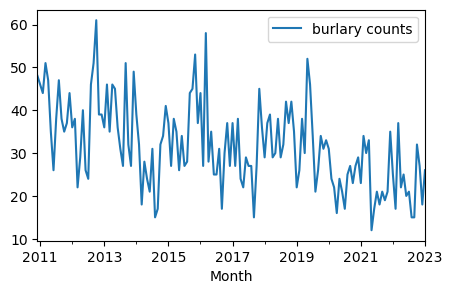

In [18]:
hendon_time.plot(kind='line',figsize=(5, 3))

<Axes: xlabel='dt_year'>

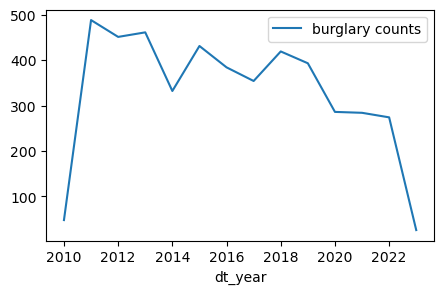

In [19]:
hendon_year.plot(kind='line',figsize=(5, 3))

<Axes: xlabel='dt_month'>

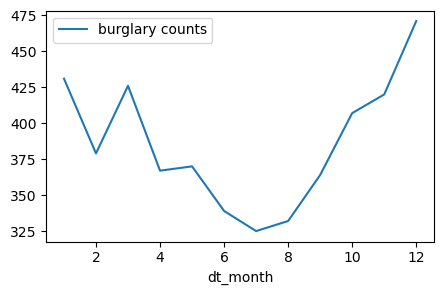

In [20]:
hendon_month.plot(kind='line',figsize=(5, 3))

### Find the area where burglary and theft happened the most in each MSOA

In [21]:
# Count the number of thefts by the location
coor_burg = hendon_burg[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')


In [22]:
# Count the number of thefts by the location
coor_theft = hendon_theft[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')


In [23]:
lsoa_burg = hendon_burg[['LSOA name']].value_counts().rename_axis(['LSOA name']).reset_index(name='Count')


In [24]:
lsoa_theft = hendon_theft[['LSOA name']].value_counts().rename_axis(['LSOA name']).reset_index(name='Count')


In [25]:
# Plot the density map
#plt.figure(figsize=(10, 8))
#plt.scatter(coor_burg['Latitude'], coor_burg['Longitude'], s=coor_burg['Count']*50, alpha=0.6)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Density Map of Theft Incidents')
#plt.show()

In [26]:
# Plot the density map

#plt.figure(figsize=(10, 8))
#plt.scatter(coor_theft['Latitude'], coor_theft['Longitude'], s=coor_theft['Count']*50, alpha=0.6)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Density Map of Theft Incidents')
#plt.show()

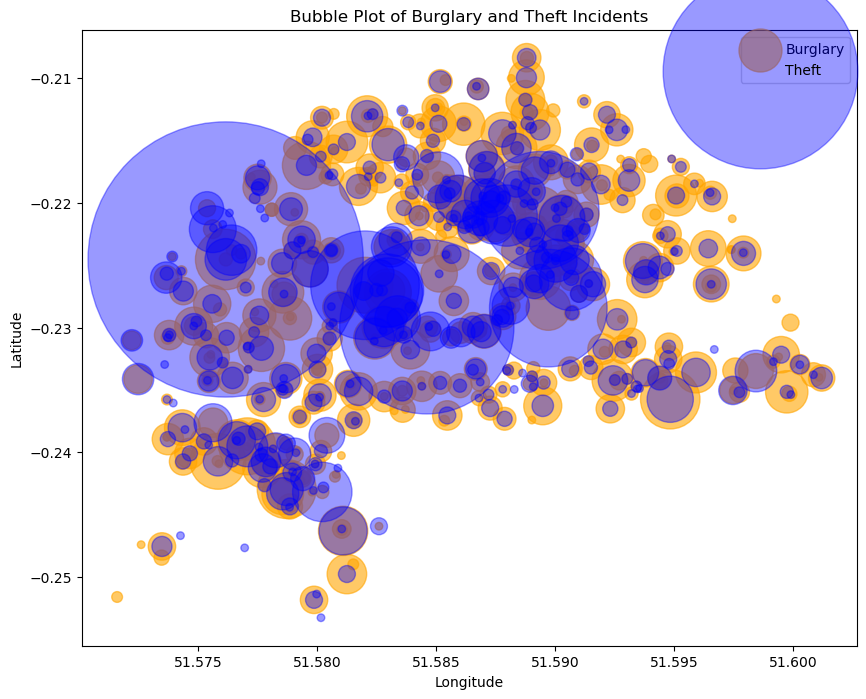

In [93]:
# Create a figure

fig, ax = plt.subplots(figsize=(10, 8))


# Plot the burglary incidents
ax.scatter(coor_burg['Latitude'],coor_burg['Longitude'], s=coor_burg['Count']*30, c='orange', alpha=0.6, label='Burglary')
# Plot the theft incidents
ax.scatter(coor_theft['Latitude'],coor_theft['Longitude'], s=coor_theft['Count']*30, c='blue', alpha=0.4, label='Theft')

#ax.scatter(centroids[:,0] , centroids[:,1] , marker="x", color='black', linewidth=2)
#ax.scatter(centroids2[:,0] , centroids2[:,1] , marker="x", color='black', linewidth=2)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Bubble Plot of Burglary and Theft Incidents')
ax.legend()

# Show the combined plot
plt.show()

# K-means cluster for burglary locations

In [27]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from scipy import interpolate
from scipy.spatial import ConvexHull
import folium

In [28]:
# Split the ward Hendon and West Hendon by their LSOA
# Ward Hendon
mask1 = (hendon_burg['LSOA name']=='Barnet 031A')|(hendon_burg['LSOA name']=='Barnet 031B')|\
        (hendon_burg['LSOA name']=='Barnet 031C')|(hendon_burg['LSOA name']=='Barnet 032A')|\
        (hendon_burg['LSOA name']=='Barnet 032B')|(hendon_burg['LSOA name']=='Barnet 032C')|\
        (hendon_burg['LSOA name']=='Barnet 032D')|(hendon_burg['LSOA name']=='Barnet 032E')|\
        (hendon_burg['LSOA name']=='Barnet 034A')|(hendon_burg['LSOA name']=='Barnet 034B')|\
        (hendon_burg['LSOA name']=='Barnet 034D')
# Ward West Hendon
mask2 = (hendon_burg['LSOA name']=='Barnet 031D')|(hendon_burg['LSOA name']=='Barnet 032F')|\
        (hendon_burg['LSOA name']=='Barnet 034C')|(hendon_burg['LSOA name']=='Barnet 039D')|\
        (hendon_burg['LSOA name']=='Barnet 036B')|(hendon_burg['LSOA name']=='Barnet 036C')|\
        (hendon_burg['LSOA name']=='Barnet 036D')|(hendon_burg['LSOA name']=='Barnet 036E')|\
        (hendon_burg['LSOA name']=='Barnet 036F')

#### Clusters for ward Hendon

In [29]:
# Split the time to 3 seasons in a year
hen_burg1 = hendon_burg[hendon_burg['dt_month'].isin([1,2,3,4])&mask1]
hen_burg1 = hen_burg1[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')
hen_burg2 = hendon_burg[hendon_burg['dt_month'].isin([5,6,7,8])&mask1]
hen_burg2 = hen_burg2[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')
hen_burg3 = hendon_burg[hendon_burg['dt_month'].isin([9,10,11,12])&mask1]
hen_burg3 = hen_burg3[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')



#### Clusters for ward West Hendon

In [30]:
# Split the time to 3 seasons in a year
west_burg1 = hendon_burg[hendon_burg['dt_month'].isin([1,2,3,4])&mask2]
west_burg1 = west_burg1[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')
west_burg2 = hendon_burg[hendon_burg['dt_month'].isin([5,6,7,8])&mask2]
west_burg2 = west_burg2[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')
west_burg3 = hendon_burg[hendon_burg['dt_month'].isin([9,10,11,12])&mask2]
west_burg3 = west_burg3[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')


In [31]:
def Kmeans_cluster(coor_df, ward):
    '''The input is the dataframe and the ward name. Returns the dataframe with extra columns :
    Kmeans centroid, clusters, and colors'''
    # Convert the counts to weights
    coor_df['weights'] = coor_df['Count']/sum(coor_df['Count'])
    X = np.array(coor_df[['Latitude', 'Longitude']])

    #Initialize the class object
    if ward == 'Hendon':
        kmeans = KMeans(n_clusters= 3, random_state=42)
    else:
        kmeans = KMeans(n_clusters= 2, random_state=42)
 
    #predict the labels of clusters.
    coor_df['cluster'] = kmeans.fit_predict(X, sample_weight=coor_df['weights'])
 
    #Getting unique labels
    u_labels = np.unique(coor_df.cluster)
    #Getting the Centroids
    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]
    ## add to df
    if ward == 'Hendon':
        coor_df['cen_x'] = coor_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
        coor_df['cen_y'] = coor_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
        # define and map colors
        colors = ['#DF2020', '#81DF20', '#2095DF']
        coor_df['c'] = coor_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
    else:
        coor_df['cen_x'] = coor_df.cluster.map({0:cen_x[0], 1:cen_x[1]})
        coor_df['cen_y'] = coor_df.cluster.map({0:cen_y[0], 1:cen_y[1]})
        colors = ['#FFA500', '#800080']
        coor_df['c'] = coor_df.cluster.map({0:colors[0], 1:colors[1]})
    
    return coor_df, centroids, colors

In [32]:
# Kmeans cluster for ward Hendon and West Hendon from Jan-April
hendon1, centroids1, color1 = Kmeans_cluster(hen_burg1, 'Hendon')
west1, w_centroids1, w_color1 = Kmeans_cluster(west_burg1, 'West Hendon')
# Kmeans cluster for ward Hendon and West Hendon from May-Aug
hendon2, centroids2, color2 = Kmeans_cluster(hen_burg2, 'Hendon')
west2, w_centroids2, w_color2 = Kmeans_cluster(west_burg2, 'West Hendon')
# Kmeans cluster for ward Hendon and West Hendon from Sep-Dec
hendon3, centroids3, color3 = Kmeans_cluster(hen_burg3, 'Hendon')
west3, w_centroids3, w_color3 = Kmeans_cluster(west_burg3, 'West Hendon')


C:\Users\xiaoyawang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\xiaoyawang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\xiaoyawang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\xiaoyawang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

In [33]:
unique_pairs = hendon1[['cen_x', 'cen_y', 'cluster']].drop_duplicates().sort_values('cluster')
print(unique_pairs)

       cen_x     cen_y  cluster
1  51.586022 -0.215705        0
0  51.594969 -0.233272        1
2  51.589657 -0.223675        2


In [34]:
centroids1

array([[51.58602187, -0.2157051 ],
       [51.59496924, -0.23327158],
       [51.58965695, -0.2236754 ]])

In [35]:
# Create a folium map object
m = folium.Map()
clusters = hendon1[['cen_x', 'cen_y', 'cluster']].drop_duplicates().sort_values('cluster')
# Plot the data points as markers on the map
for lat, lon, c in zip(hendon1.Latitude,hendon1.Longitude, hendon1.c):
    folium.CircleMarker([lat, lon], radius=5, color=c, fill_color=c, fill_opacity=0.7).add_to(m)
for lat, lon, c in zip(west1.Latitude,west1.Longitude, west1.c):
    folium.CircleMarker([lat, lon], radius=5, color=c, fill_color=c, fill_opacity=0.7).add_to(m)
    
# Plot the centroid points as markers on the map with labels
for lat, lon, color, cluster in zip([i[0] for i in centroids1], [i[1] for i in centroids1], color1, range(len(centroids1))):
    folium.Marker([lat, lon], icon=folium.Icon(icon='shield', prefix='fa', color='darkblue'),
                  tooltip="Hendon Cluster {}".format(cluster),
                  popup=folium.Popup("<b>Cluster {}: Centroid</b>".format(cluster))).add_to(m)

for lat, lon, color, cluster in zip([i[0] for i in w_centroids1], [i[1] for i in w_centroids1], w_color1, range(len(w_centroids1))):
    folium.Marker([lat, lon], icon=folium.Icon(icon='shield', prefix='fa', color='darkblue'),
                  tooltip="West Hendon Cluster {}".format(cluster),
                  popup=folium.Popup("<b>Cluster {}: Centroid</b>".format(cluster))).add_to(m)
m

# plot data
#plt.scatter(hendon1.Latitude,hendon1.Longitude, c=hendon1.c, alpha = 0.6, s=10)
#plt.scatter(west1.Latitude,west1.Longitude, c=west1.c, alpha = 0.6, s=10)
#plt.scatter([i[0] for i in centroids1] , [i[1] for i in centroids1], marker='^', c=color1, s=70)
#plt.scatter([i[0] for i in w_centroids1] , [i[1] for i in w_centroids1], marker='^', c=w_color1, s=70)


# create a list of legend elemntes
## markers / records
#legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               #markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(color1)]

#w_legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+4), 
               #markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(w_color1)]

# Combine the two lists of legend elements
#all_legend_elements = legend_elements + w_legend_elements

# plot legend
#plt.legend(handles=all_legend_elements, loc='upper right')
# title and labels
#plt.title('Burglary locations for Jan-April', loc='left', fontsize=22)
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')


In [36]:
# Create a folium map object
m = folium.Map()

# Plot the data points as markers on the map
for lat, lon, c in zip(hendon3.Latitude,hendon3.Longitude, hendon3.c):
    folium.CircleMarker([lat, lon], radius=5, color=c, fill_color=c, fill_opacity=0.7).add_to(m)
for lat, lon, c in zip(west3.Latitude,west3.Longitude, west3.c):
    folium.CircleMarker([lat, lon], radius=5, color=c, fill_color=c, fill_opacity=0.7).add_to(m)
    
# Plot the centroid points as markers on the map with labels
for lat, lon, color, cluster in zip([i[0] for i in centroids1], [i[1] for i in centroids1], color1, range(len(centroids1))):
    folium.Marker([lat, lon], icon=folium.Icon(icon='shield', prefix='fa', color='darkblue'),
                  tooltip="Hendon Cluster {}".format(cluster),
                  popup=folium.Popup("<b>Cluster {}: Centroid</b>".format(cluster))).add_to(m)

for lat, lon, color, cluster in zip([i[0] for i in w_centroids1], [i[1] for i in w_centroids1], w_color1, range(len(w_centroids1))):
    folium.Marker([lat, lon], icon=folium.Icon(icon='shield', prefix='fa', color='darkblue'),
                  tooltip="West Hendon Cluster {}".format(cluster),
                  popup=folium.Popup("<b>Cluster {}: Centroid</b>".format(cluster))).add_to(m)
m


In [160]:
from scipy.spatial.distance import cdist
from geopy.distance import geodesic

In [183]:
# Calculate the Euclidean distance between the centroids for different seasons
distance1 = np.mean([geodesic(centroids1[0], centroids2[0]).meters, geodesic(centroids1[0], centroids3[1]).meters,
            geodesic(centroids2[0], centroids3[1]).meters])
distance2 = np.mean([geodesic(centroids1[1], centroids2[1]).meters, geodesic(centroids1[1], centroids3[0]).meters,
            geodesic(centroids2[1], centroids3[0]).meters])
distance3 = np.mean([geodesic(centroids1[2], centroids2[2]).meters, geodesic(centroids1[2], centroids3[2]).meters,
            geodesic(centroids2[2], centroids3[2]).meters])
distance1, distance2, distance3

(40.298829156318995, 31.342484535696922, 41.14509048261834)

In [168]:
centroids1, centroids2, centroids3

(array([[51.58602187, -0.2157051 ],
        [51.59496924, -0.23327158],
        [51.58965695, -0.2236754 ]]),
 array([[51.58552048, -0.21600538],
        [51.59480099, -0.2336134 ],
        [51.58927906, -0.22349034]]),
 array([[51.59472332, -0.23312807],
        [51.58583613, -0.21592894],
        [51.58978682, -0.22342123]]))

https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489

### Total number of burglary in each cluster

In [219]:
grouped_hendon1 = hendon1.groupby('cluster')[['Count']].sum().reset_index()
# Define the mapping dictionary
cluster_mapping = {0: "Hendon cluster 0", 1: "Hendon cluster 1", 2: "Hendon cluster 2"}
# Replace the cluster labels with the desired names
grouped_hendon1['cluster'] = grouped_hendon1['cluster'].replace(cluster_mapping)
grouped_hendon2 = hendon2.groupby('cluster')[['Count']].sum().reset_index()
grouped_hendon2['cluster'] = grouped_hendon2['cluster'].replace(cluster_mapping)
grouped_hendon3 = hendon3.groupby('cluster')[['Count']].sum().reset_index()
grouped_hendon3['cluster'] = grouped_hendon3['cluster'].replace(cluster_mapping)

cluster_mapping2 = {0: "West Hendon cluster 0", 1: "West Hendon cluster 1"}
grouped_west1 = west1.groupby('cluster')[['Count']].sum().reset_index()
grouped_west1['cluster'] = grouped_west1['cluster'].replace(cluster_mapping2)
grouped_west2 = west2.groupby('cluster')[['Count']].sum().reset_index()
grouped_west2['cluster'] = grouped_west2['cluster'].replace(cluster_mapping2)
grouped_west3 = west3.groupby('cluster')[['Count']].sum().reset_index()
grouped_west3['cluster'] = grouped_west3['cluster'].replace(cluster_mapping2)

# Concat dataframe that are in the same seasons
whole_hendon1 = pd.concat([grouped_hendon1, grouped_west1], ignore_index=True)
whole_hendon2 = pd.concat([grouped_hendon2, grouped_west2], ignore_index=True)
whole_hendon3 = pd.concat([grouped_hendon3, grouped_west3], ignore_index=True)

# Calculate the percentage of count
whole_hendon1['Count percent'] = whole_hendon1['Count']/sum(whole_hendon1['Count'])
whole_hendon2['Count percent'] = whole_hendon2['Count']/sum(whole_hendon2['Count'])
whole_hendon3['Count percent'] = whole_hendon3['Count']/sum(whole_hendon3['Count'])

In [222]:
whole_hendon1, whole_hendon2, whole_hendon3

(                 cluster  Count  Count percent
 0       Hendon cluster 0    377       0.235184
 1       Hendon cluster 1    196       0.122271
 2       Hendon cluster 2    389       0.242670
 3  West Hendon cluster 0    327       0.203993
 4  West Hendon cluster 1    314       0.195883,
                  cluster  Count  Count percent
 0       Hendon cluster 0    313       0.229136
 1       Hendon cluster 1    151       0.110542
 2       Hendon cluster 2    369       0.270132
 3  West Hendon cluster 0    280       0.204978
 4  West Hendon cluster 1    253       0.185212,
                  cluster  Count  Count percent
 0       Hendon cluster 0    198       0.119134
 1       Hendon cluster 1    375       0.225632
 2       Hendon cluster 2    439       0.264140
 3  West Hendon cluster 0    308       0.185319
 4  West Hendon cluster 1    342       0.205776)

## Trend of theft counts

In [63]:
grouped_time = df_burg.groupby('Month')[['Crime type']].count()
burg_time = grouped_time.rename(columns={'Crime type':'burglary counts'}).reset_index()
grouped_theft = df_theft.groupby('Month')[['Crime type']].count()
theft_time = grouped_theft.rename(columns={'Crime type':'theft counts'}).reset_index()

In [68]:
burg_time

,Month,burglary counts
0,2010-12,372
1,2011-01,486
2,2011-02,403
3,2011-03,408
4,2011-04,414
...,...,...
141,2022-09,189
142,2022-10,248
143,2022-11,246
144,2022-12,228


In [65]:
joined_time = pd.merge(burg_time, theft_time, on='Month', how='outer')
joined_time['theft lag1'] = joined_time['theft counts'].shift(1)
joined_time['burg lag1'] = joined_time['burglary counts'].shift(1)
joined_time['theft lag2'] = joined_time['theft counts'].shift(2)
joined_time['burg lag2'] = joined_time['burglary counts'].shift(2)
joined_time['theft lag2'] = joined_time['theft counts'].shift(2)
joined_time['burg lag2'] = joined_time['burglary counts'].shift(2)
# Drop rows with null values
joined_time.dropna(inplace=True)


In [66]:
# find correlation between burglary, theft counts, and theft lag 1 month counts
# Calculate the correlation matrix
correlation_matrix = joined_time.corr()

# Print the correlation matrix
print(correlation_matrix)

                 burglary counts  theft counts  theft lag1  burg lag1  \
burglary counts         1.000000      0.591067    0.609937   0.767374   
theft counts            0.591067      1.000000    0.788669   0.544041   
theft lag1              0.609937      0.788669    1.000000   0.592970   
burg lag1               0.767374      0.544041    0.592970   1.000000   
theft lag2              0.575665      0.673308    0.788085   0.608596   
burg lag2               0.661513      0.498594    0.543735   0.763264   

                 theft lag2  burg lag2  
burglary counts    0.575665   0.661513  
theft counts       0.673308   0.498594  
theft lag1         0.788085   0.543735  
burg lag1          0.608596   0.763264  
theft lag2         1.000000   0.595167  
burg lag2          0.595167   1.000000  


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_20344\1633203733.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = joined_time.corr()


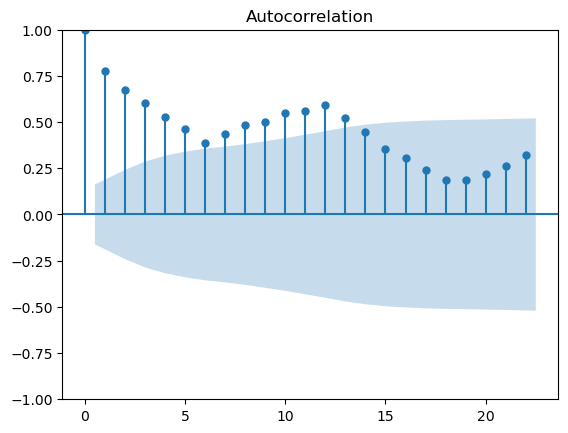

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


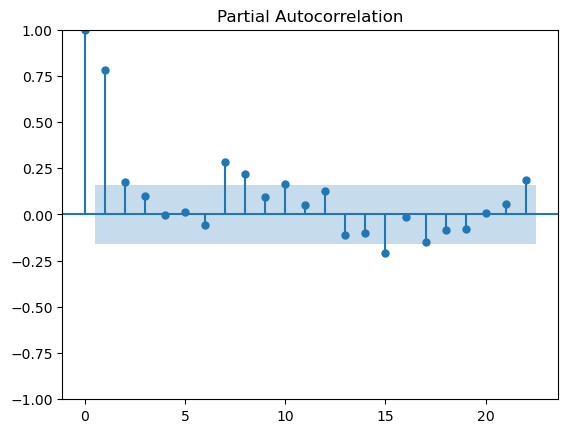

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(burg_time['burglary counts'])
plt.show()

plot_pacf(burg_time['burglary counts'])
plt.show()

In [61]:
# Calculate the interval time in months between each location
grouped_loc = df_burg.groupby(['Latitude','Longitude','Month']).count()

# Print the dataframe with the interval time
grouped_loc

Crime ID  Reported by  Falls within  Location  \
Latitude  Longitude Month                                                    
51.555863 -0.205710 2013-07         1            1             1         1   
                    2016-06         3            3             3         3   
                    2017-07         2            2             2         2   
                    2017-10         1            1             1         1   
51.555917 -0.212776 2011-06         0            2             2         2   
...                               ...          ...           ...       ...   
51.666877 -0.198912 2011-06         0            1             1         1   
51.667988 -0.195715 2011-03         0            1             1         1   
51.668072 -0.195929 2013-11         1            1             1         1   
                    2014-05         1            1             1         1   
                    2019-10         1            1             1         1   

                             LSOA code  LSOA name  Crime type  \
Latitude  Longitude Month                                       
51.555863 -0.205710 2013-07          1          1           1   
                    2016-06          3          3           3   
                    2017-07          2          2           2   
                    2017-10          1          1           1   
51.555917 -0.212776 2011-06          2          2           2   
...                                ...        ...         ...   
51.666877 -0.198912 2011-06          1          1           1   
51.667988 -0.195715 2011-03          1          1           1   
51.668072 -0.195929 2013-11          1          1           1   
                    2014-05          1          1           1   
                    2019-10          1          1           1   

                             Last outcome category  Context  MSOA  
Latitude  Longitude Month                                          
51.555863 -0.205710 2013-07                      1        0     1  
                    2016-06                      3        0     3  
                    2017-07                      2        0     2  
                    2017-10                      1        0     1  
51.555917 -0.212776 2011-06                      0        0     2  
...                                            ...      ...   ...  
51.666877 -0.198912 2011-06                      0        0     1  
51.667988 -0.195715 2011-03                      0        0     1  
51.668072 -0.195929 2013-11                      1        0     1  
                    2014-05                      1        0     1  
                    2019-10                      1        0     1  

[37841 rows x 10 columns]

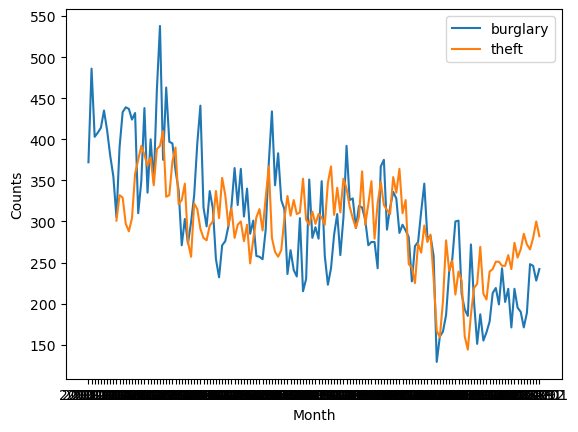

In [81]:
# Create a line plot
plt.plot(burg_time['Month'], burg_time['burglary counts'], label='burglary')
plt.plot(theft_time['Month'], theft_time['theft counts'], label='theft')

# Add labels and a legend
plt.xlabel('Month')
plt.ylabel('Counts')
plt.legend()

# Display the plot
plt.show()

In [82]:
df_theft['Month'] = pd.to_datetime(df_theft['Month']).dt.to_period('M')
df_theft['dt_year'] = df_theft['Month'].dt.year
df_theft['dt_month'] = df_theft['Month'].dt.month

C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_22560\1012661188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_theft['Month'] = pd.to_datetime(df_theft['Month']).dt.to_period('M')
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_22560\1012661188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_theft['dt_year'] = df_theft['Month'].dt.year
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_22560\1012661188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [83]:
grouped_year = df_theft.groupby('dt_year')[['Crime type']].count()
grouped_year = grouped_year.rename(columns={'Crime type':'theft counts'})
grouped_month = df_theft.groupby('dt_month')[['Crime type']].count()
grouped_month = grouped_month.rename(columns={'Crime type':'theft counts'})

<Axes: xlabel='dt_month'>

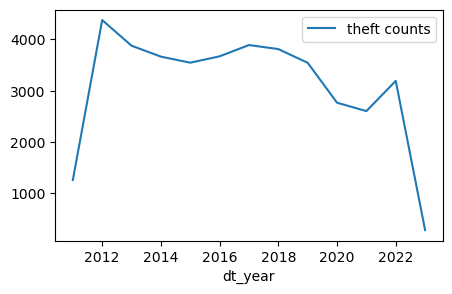

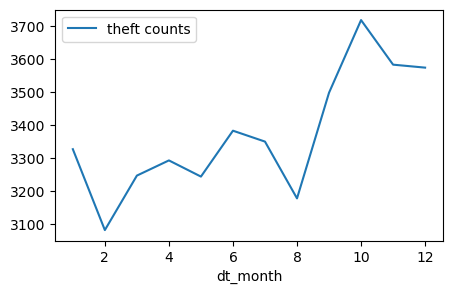

In [84]:
grouped_year.plot(kind='line',figsize=(5, 3))
grouped_month.plot(kind='line',figsize=(5, 3))